# Intro to coffea.hist

A histogram in Coffea is a `N-D` collection of different categories, along with bin(s)

Let's start by importing some necessary libraries

In [1]:
from coffea import hist
import matplotlib.pyplot as plt #plot histograms
import numpy as np

Simple example from the Coffea manual

In [2]:
h = hist.Hist("Observed bird count",
               hist.Cat("species", "Bird species"),
               hist.Bin("x", "x coordinate [m]", 20, -5, 5),
               hist.Bin("y", "y coordinate [m]", 20, -5, 5),
             )

Now we'ss use `fill()` to add 10 `ducks`, with random `x-y` values using `numpy.random`, each with a weight of 3

In [3]:
h.fill(species='ducks', x=np.random.normal(size=10), y=np.random.normal(size=10), weight=np.ones(10) * 3)

Now I'll add another species

In [4]:
h.fill(species='phoenix', x=np.random.normal(size=1), y=np.random.normal(size=1), weight=np.ones(1))

Let's create a plot to draw everthing in using matplotlib and the `plot2d()` method in `coffea.hist`

In [5]:
h.integrate('species')

<Hist (x,y) instance at 0x7f00e9f34700>

<AxesSubplot:xlabel='x coordinate [m]', ylabel='y coordinate [m]'>

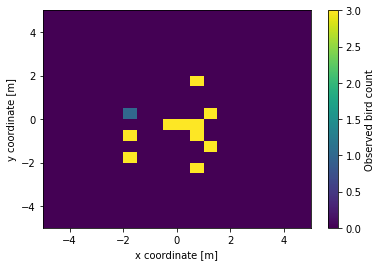

In [6]:
hist.plot2d(h.integrate('species'), xaxis='x')

Now we can play with the axes to learn some more<br>
We can view the axes with `h.axes()`

In [7]:
h.axes()

(<Cat (name=species) instance at 0x7f00e9f34040>,
 <Bin (name=x) instance at 0x7f00e9f340a0>,
 <Bin (name=y) instance at 0x7f00e9f34100>)

We can remove the `x`-axis by integrating it out with `integrate()`

In [8]:
h.integrate('x').integrate('species')

<Hist (y) instance at 0x7f00e1da9b50>

And now we can make a `1D` plot, in this case of `species` and `y coordinate`

<AxesSubplot:xlabel='y coordinate [m]', ylabel='Observed bird count'>

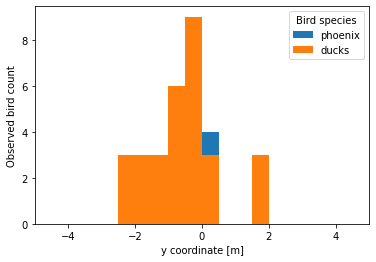

In [9]:
hist.plot1d(h.integrate('x'), stack=True) #stack makes a stack plot

## A more pratical, physics example

In this example, I'll load a set of histograms from ```histos/plotsTopEFT.pkl.gz```<br>
This is a pickle file created by TopCoffea

First, let's import all the relevent packages (same as before, but here to make this section stand alone)

In [10]:
import pickle #read pickle file
from coffea import hist
import topcoffea.modules.HistEFT as HistEFT
import gzip #read zipped pickle file
import matplotlib.pyplot as plt #plot histograms
import numpy as np

Next, we'll open the pickle file, and load its histograms into a dictionary

In [11]:
!mkdir -p histos
!wget -nc https://cernbox.cern.ch/index.php/s/kTpTo2FXFyMofO9/download -O ../histos/ttH_private_UL17_fixWeights_nosyst.pkl.gz
fin = '../histos/ttH_private_UL17_fixWeights_nosyst.pkl.gz'
hists = {} #dictionary of histograms
with gzip.open(fin) as fin:
  hin = pickle.load(fin)
  for k in hin.keys():
    if k in hists: hists[k]+=hin[k]
    else:               hists[k]=hin[k]

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
File ‘../histos/ttH_private_UL17_fixWeights_nosyst.pkl.gz’ already there; not retrieving.


Now we'll grab the histogram for `njets`

In [12]:
h = hists['njets'] #load histogram of njets distribution

Each histogram is a `N-D` collection of different categories

In [13]:
h.axes() #all axes in this version

(<Cat (name=sample) instance at 0x7f00e1c9f700>,
 <Cat (name=channel) instance at 0x7f00e1c9f7c0>,
 <Cat (name=cut) instance at 0x7f00e1c9fee0>,
 <Cat (name=sumcharge) instance at 0x7f01c57fc160>,
 <Cat (name=systematic) instance at 0x7f01c57fc2b0>,
 <Bin (name=njets) instance at 0x7f01c57fc370>)

You can retrieve the histogram's bin contents with the `values()` method

In [14]:
h.values() #this is large, and Jupyter wants to show the whole thing
print(list(h.values())[0],'...') #just print the first entry

('ttHJet_privateUL17', 'eeSSonZ', 'base', 'ch+', 'nominal') ...


To select a specific label in a category we must use `integrate()` (the other option is `sum()` which combines all the lables in a category together)

In [15]:
ch3l = ['eemSSonZ', 'eemSSoffZ', 'mmeSSonZ', 'mmeSSoffZ','eeeSSonZ', 'eeeSSoffZ', 'mmmSSonZ', 'mmmSSoffZ'] #define ch3l to make things cleaner
h = h.integrate('cut','base').integrate('channel',ch3l).integrate('sumcharge', 'ch+').integrate('systematic', 'nominal')

We've now integrated outeverything but the type of samples:

In [16]:
h.values()

{('ttHJet_privateUL17',): array([ 0.82102323,  5.62082362, 15.61190066, 21.63265989, 18.14233064,
        10.39812135,  4.65439359,  1.76298776,  0.54739521,  0.16933985])}

In [17]:
h.axes()

(<Cat (name=sample) instance at 0x7f00e1c9f700>,
 <Bin (name=njets) instance at 0x7f01c57fc370>)

Let's create a plot to draw everthing in using matplotlib and the `plot1d()` method in `coffea.hist`

<AxesSubplot:xlabel='Jet multiplicity ', ylabel='Events'>

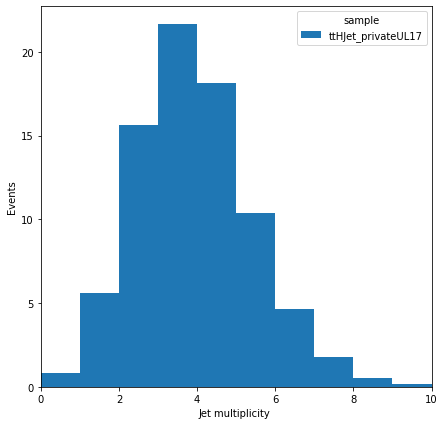

In [18]:
fig, ax = plt.subplots(1,1, figsize=(7,7)) #create an axis for plotting
hist.plot1d(h, stack=True)
#fig.show() #not needed in Jupyter, but this draws the figure in the terminal

# topcoffea.modules.HistEFT

I'll continue using the ```histos/plotsTopEFT.pkl.gz``` file from above<br>
Now we'll use methods that are unique to HistEFT (e.g. `set_wilson_coefficients()` to scale the Wilson Coefficient (WC) values)

The `HistEFT` class holds the structure constants ($S_0, S_{1j}, S_{2j},$ and $S_{3jk}$) we solved for when partins the EFT files, so the event yields are just a function of the WCs ($\vec{c}$):

\begin{equation}
N\left(\dfrac{\vec{c}}{\Lambda^2}\right) = S_0 + \sum_j S_{1j} \frac{c_j}{\Lambda^2} + \sum_j S_{2j} \frac{c_j^2}{\Lambda^4} + \sum_{j,k} S_{3jk} \frac{c_j}{\Lambda^2} \frac{c_k}{\Lambda^2}
\end{equation}

First, we'll scale the histogram to the SM (all `WCs=0`)

In [19]:
h.set_wilson_coefficients(np.zeros(h._nwc))

where `_nwc` is a local variable inside a HistEFT that stores how many WCs it contains<br>
The WCs are used whenever `values()` method is called

In [20]:
h.values()

{('ttHJet_privateUL17',): array([ 0.82102323,  5.62082362, 15.61190066, 21.63265989, 18.14233064,
        10.39812135,  4.65439359,  1.76298776,  0.54739521,  0.16933985])}

Plotting this should look the same as before, since by default the WCs are 0

<AxesSubplot:xlabel='Jet multiplicity ', ylabel='Events'>

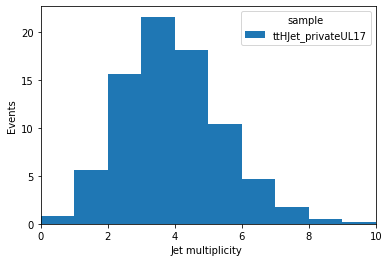

In [21]:
hist.plot1d(h, stack=True)

Now let's set them all to 1 to see that things change

In [22]:
h.set_wilson_coefficients(np.ones(h._nwc))

In [23]:
h.values()

{('ttHJet_privateUL17',): array([  4.27789255,  28.60721737,  76.79289754, 111.01972767,
         95.63147129,  58.47256592,  26.36142483,  10.54020613,
          4.24346426,   1.07172759])}

<AxesSubplot:xlabel='Jet multiplicity ', ylabel='Events'>

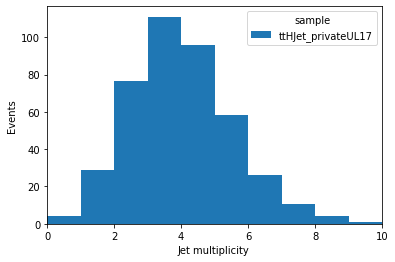

In [24]:
hist.plot1d(h, stack=True)

You might have noticed these plots are not giving event yields.<br>
The EFT samples come normalized to $\sigma * w_{\mathrm{gen}}$<br>
In order to produce event yeilds, we must scale them by $\frac{\mathcal{L}}{\sum{w_{\mathrm{event}}^{\mathrm{SM}}}}$ , where $\sum{w_{\mathrm{event}}^{\mathrm{SM}}}$ is the sum of the event weights, evaluated at the SM.

First, load the `SumOfEFTweights` histogram

In [25]:
sow = hists['SumOfEFTweights'] #get histogram with sum of EFT weights

Next, set the WCs to the SM values of 0

In [26]:
sow.set_wilson_coefficients(np.zeros(sow._nwc)) #set to SM

Now sum over all the samples

In [27]:
sow = sow.sum('sample')

Finally, get the stored value

In [28]:
smsow = sow.values()[()][0]
print('Sum of EFT weights', smsow)

Sum of EFT weights 39430.66101814882


Now we can scale the desired histogram by $\frac{\mathcal{L}}{\sum{w_{\mathrm{event}}^{\mathrm{SM}}}}$

In [29]:
wgt = 1000*59.7/smsow
print('Scaling by', wgt)
h.scale(wgt) #2018 lumi of 59.7 fb^-1

Scaling by 1.514050194911056


<AxesSubplot:xlabel='Jet multiplicity ', ylabel='Events'>

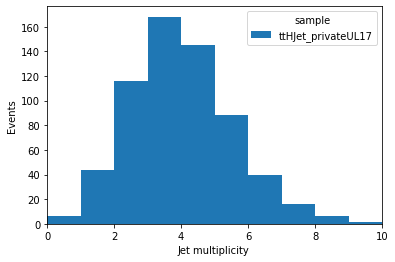

In [30]:
hist.plot1d(h, stack=True)